### Forecasting in Aquaponics

Libraries and setup

In [199]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# np.set_printoptions(threshold=sys.maxsize)

mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition

### Data adquisition

In [200]:
def read_file(textfile):
    df = pd.read_csv(textfile, compression='zip', sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_04012021_04302021.txt.zip"
df = read_file(textfile)

Dataset ready


Organize data in columns

In [201]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-04-01 00:00:00')
end_date = pd.to_datetime('2021-04-07 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head)

<bound method NDFrame.head of Label                      1          2    3       4       5          6    \
DateTime                                                                    
2021-04-01 00:00:12  20.880000  51.345560  0.0  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.096670  0.0  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.175000  0.0  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.800000  0.0  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.686670  0.0  6.6596  6.6731  42.650578   
...                        ...        ...  ...     ...     ...        ...   
2021-04-07 23:58:09  18.690002  47.212223  0.0  6.6029  6.6688  50.691600   
2021-04-07 23:58:34  18.702003  46.958890  0.0  6.6029  6.6688  50.704353   
2021-04-07 23:59:00  18.727503  46.798890  0.0  6.6030  6.6688  50.692642   
2021-04-07 23:59:25  18.697998  46.917778  0.0  6.6030  6.6686  50.689896   
2021-04-07 23:59:49  18.692000  47.322224  0.0

Data visualization

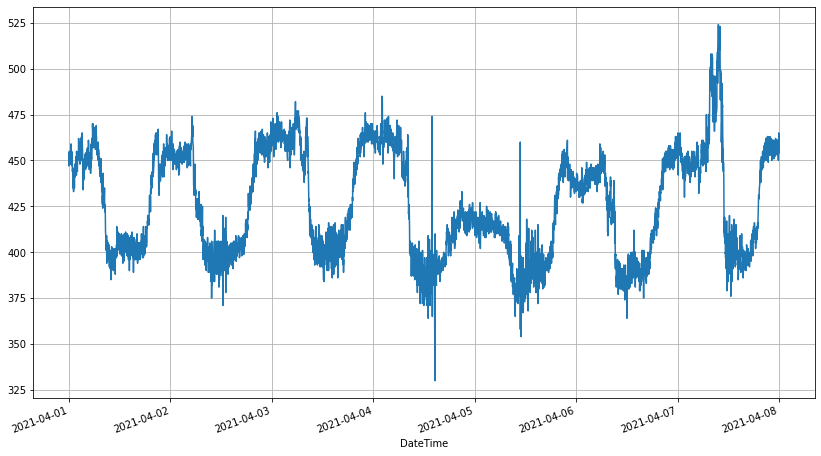

In [202]:
sample_sensor = 18

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 18    = C02
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A
* sensors are not online yet*

In [203]:
label_target = {5: 'pH sump A',  
                9: '% oxygen A'}


### Select features - Human knowledge

In [204]:
drop_signal = [3, 12, 13, 14, 15, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.head())

Label                      1         2       4       5          6    \
DateTime                                                              
2021-04-01 00:00:12  20.880000  51.34556  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  6.6596  6.6731  42.650578   

Label                      7       8       9       10      11   ...    91   \
DateTime                                                        ...          
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  13.528  ...  406.0   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  13.512  ...  406.0   
2021-04-01 00:06:23  49.073135  99

### Denoising dataframe - FFT filter

Check sampling frecuency

In [205]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

0 days 00:00:25


Design sample filter

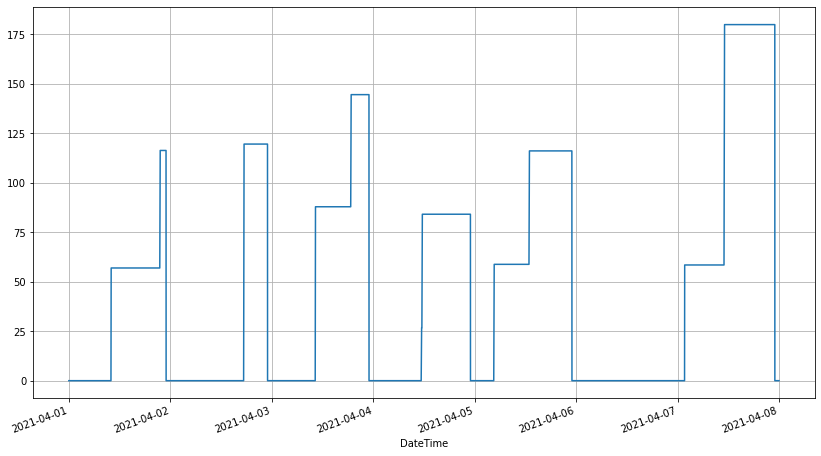

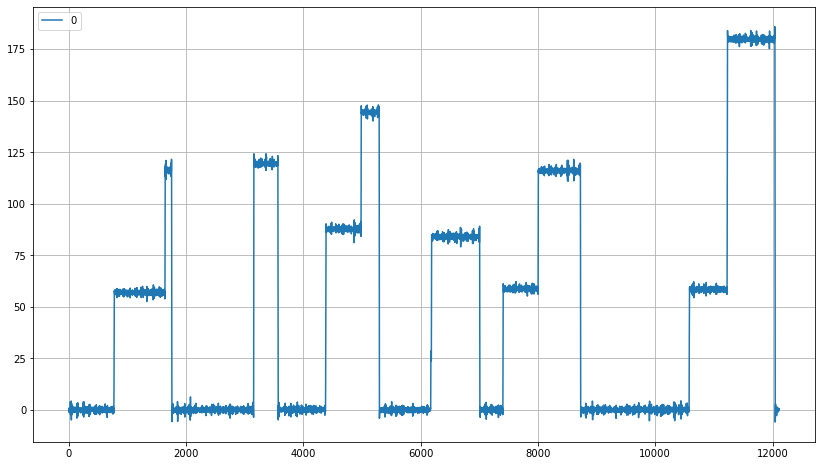

In [240]:
def f_filtering(df):
    
    new_df = df.copy() 
    index = df.index
    
    dt = 25 # seconds
    n_samples = new_df.shape[0]
    
    f_hat = np.fft.fft(df)
    f_mag_2 = np.real(f_hat * np.conj(f_hat)) / n_samples
    fc_df = (1 / (dt * n_samples)) * np.arange(n_samples)
    
#     plt.step(fc_df, f_mag_2)
#     plt.xlabel('Frecuency [Hz]')
#     plt.ylabel('Magnitude')
#     plt.show()
    
    ind_filter = f_mag_2 > 20
    f_hat_clean = f_hat * ind_filter
    filter_signal = np.fft.ifft(f_hat_clean)
    
    new_df = pd.DataFrame(np.real(filter_signal))
    
    return new_df

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

df_clean = f_filtering(df_grouped[sample_sensor])

new_df.plot() #(x = 'DateTime', y = 'Value', kind = 'line')
# plt.xticks(rotation=20)
plt.show()

### Feature selection via correlation analysis

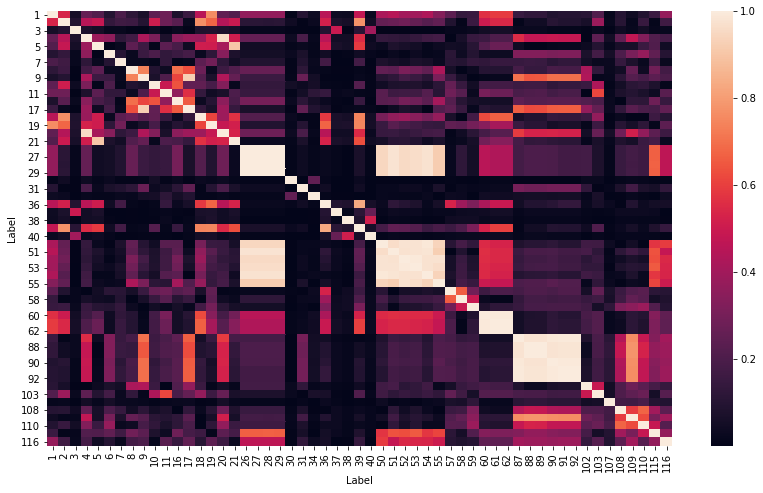

Label                     2       4       5       8       9       16      17   \
DateTime                                                                        
2021-04-01 00:00:12  51.34556  6.6498  6.6667  99.262  95.587  10.849  10.051   
2021-04-01 00:00:38  51.09667  6.6498  6.6667  99.262  95.587  10.849  10.051   
2021-04-01 00:01:04  51.17500  6.6514  6.6681  99.255  95.599  10.855  10.056   
2021-04-01 00:05:57  50.80000  6.6584  6.6718  99.289  95.774  10.872  10.087   
2021-04-01 00:06:23  50.68667  6.6596  6.6731  99.273  95.758  10.871  10.087   

Label                  18     19         20   ...       55   61   62      87   \
DateTime                                      ...                               
2021-04-01 00:00:12  450.0  22.33  12.549996  ...  0.003599  0.0  0.0  1339.0   
2021-04-01 00:00:38  447.0  22.33  12.549996  ...  0.003625  0.0  0.0  1339.0   
2021-04-01 00:01:04  448.0  22.35  12.149930  ...  0.003650  0.0  0.0  1339.0   
2021-04-01 00:05:57  454.0 

In [46]:
corr_mat = np.abs(df_grouped.corr(method='pearson'))
sns.heatmap(corr_mat)
plt.show()

corr_thl = 0.25
corr_label = np.zeros(df_grouped.shape[1])

for i in label_target:
    corr_label = corr_label | (corr_mat[i] > corr_thl)

df_grouped = df_grouped.loc[:, corr_label]
print(df_grouped.head())

Describe  dataset

In [9]:
print(df_grouped.describe().transpose())

         count         mean         std          min          25%  \
Label                                                               
1      12112.0    19.485984    1.688538    14.888001    18.344002   
2      12112.0    42.316472   11.238373    15.972223    33.553055   
4      12112.0     6.656971    0.034348     6.241000     6.635200   
5      12112.0     6.675761    0.017820     6.615500     6.666000   
6      12112.0    45.654572    2.548799    33.928627    43.985557   
8      12112.0    99.537764    1.644022    95.148000    98.619000   
9      12112.0    93.511280    2.110131    88.220000    92.001000   
10     12112.0    12.977850    0.734396    11.117000    12.459000   
16     12112.0    10.565443    0.229608     9.811800    10.414000   
17     12112.0     9.852646    0.266720     9.000000     9.652800   
18     12112.0   426.076288   28.521932   330.000000   400.000000   
19     12112.0    21.454848    3.302135    15.059999    19.070000   
20     12112.0    11.351885    7.2

## Split dataset: train, validation and test

In [10]:
total_data = len(df_grouped)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_grouped[0:int(total_data*train_perc)]
val_df      = df_grouped[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_grouped[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Mean-STD normalization

In [11]:
def f_normalize_meanstd(df, train_df):
    norm_mean   = train_df.mean()
    norm_std    = train_df.std()
    
    norm_df = (df - norm_mean) / norm_std
    return norm_df

def f_inv_normalize_meanstd(norm_df, train_df):
    norm_mean   = train_df.mean()
    norm_std    = train_df.std()
    
    df = norm_df * norm_std + norm_mean
    return df

norm_train_df   = f_normalize_meanstd(train_df, train_df)
norm_val_df     = f_normalize_meanstd(val_df, train_df)
norm_test_df    = f_normalize_meanstd(test_df, train_df)

Min-max normalization

In [12]:
def f_normalize_minmax(df, train_df):
    norm_df = (df - train_df.min()) / (train_df.max() - train_df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, train_df):
    df = norm_df * (train_df.max() - train_df.min()) + train_df.min()
    return df

# norm_train_df   = f_normalize_minmax(train_df, train_df)
# norm_val_df     = f_normalize_minmax(val_df, train_df)
# norm_test_df    = f_normalize_minmax(test_df, train_df)

Show tails with box plot

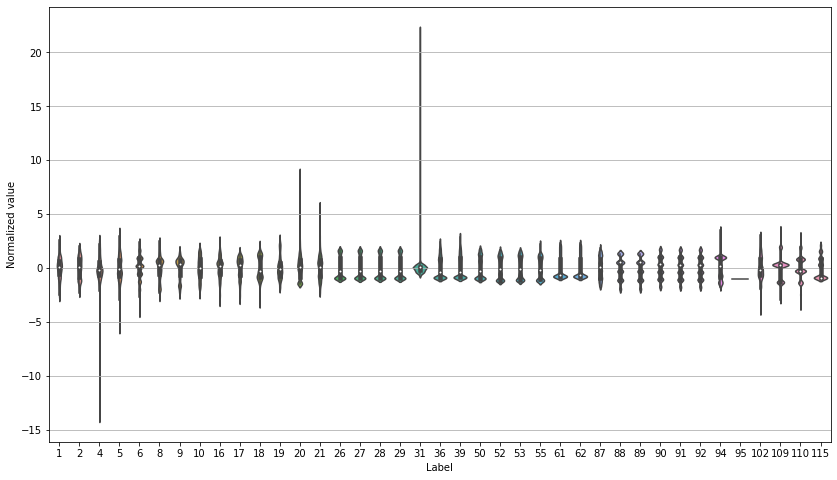

In [13]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

## Create input and target dataframe - Window generation

In [14]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 1
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('C'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [15]:
def plot_results(label_target, label_time, label, results):
    n_label = np.int(len(label_target))
    n_time = np.int(label_time.shape[0])

    m_label = label.reshape(n_time, n_label)
    m_results = results.reshape(n_time, n_label)

    sensor_tag = list(label_target.values())

    fig, ax = plt.subplots(n_label, sharex = 'all')

    for i in range(n_label):
        ax[i].plot(label_time, m_label[:, i], color = 'blue', label = 'Real')
        ax[i].plot(label_time, m_results[:, i], color = 'orange', label = 'Prediction')
        ax[i].set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.show()

    pass

Plotting - History

In [16]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Model architecture

### Linear model

In [17]:
def f_linear_model(label_target, label_width):
    linear_model = tf.keras.Sequential([
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units = 40),
                    tf.keras.layers.Dense(units = 15),
                    tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return linear_model

linear_model = f_linear_model(label_target, label_width)

### MLP model

In [18]:
def f_mlp_model(label_target, label_width):
    mlp_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units = 65*10, activation = 'relu'),
                tf.keras.layers.Dense(units = 65*5, activation = 'relu'),
                tf.keras.layers.Dense(units = 65, activation = 'relu'),
                tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return mlp_model
    
mlp_model = f_mlp_model(label_target, label_width)

### RNN - LSTM

In [19]:
def f_lstm_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.LSTM(units = 65 * 10, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.LSTM(units = 65 * 5, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.LSTM(units = 65 * 2, input_shape = input_shape),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

### RNN - GRU

In [20]:
def f_gru_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.GRU(units = 65 * 10, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.GRU(units = 65 * 5, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.GRU(units = 65 * 2, input_shape = input_shape),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

## Deployment

Callbacks

In [21]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

Training method

In [22]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, test_data, test_target, max_epochs, batch_size, test_entry):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 4)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 2,
                        shuffle = False, 
                        validation_data = (val_data, val_target),
                        callbacks = callbacks)

    model.evaluate(test_data, test_target)

    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = test_prediction.reshape(label_width, len(label_target))

    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction)

    plot_history(history)

    return history, test_prediction

max_epochs = 15
batch_size = 36
test_entry = np.random.randint(0, 100)

## Linear model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
232/232 - 1s - loss: 1.2353 - mean_absolute_error: 0.8648 - val_loss: 16.9295 - val_mean_absolute_error: 3.2267

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
232/232 - 0s - loss: 1.2589 - mean_absolute_error: 0.8506 - val_loss: 11.8078 - val_mean_absolute_error: 2.5945

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
232/232 - 0s - loss: 0.7872 - mean_absolute_error: 0.6737 - val_loss: 5.9597 - val_mean_absolute_error: 1.7440

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
232/232 - 0s - loss: 0.4832 - mean_absolute_error: 0.5235 - val_loss: 4.4299 - val_mean_absolute_error: 1.5168

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
232/232 - 0s - loss: 0.3588 - mean_absolute_error: 0.4491 - val_loss: 3.73

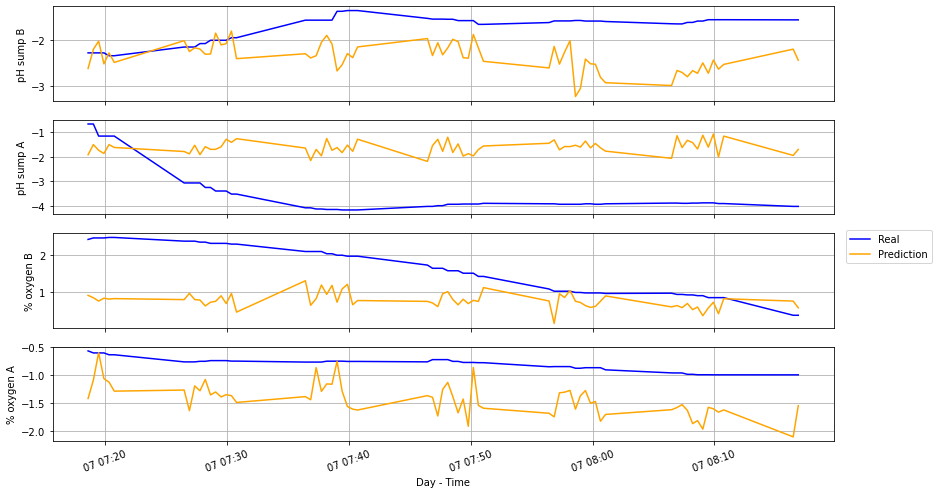

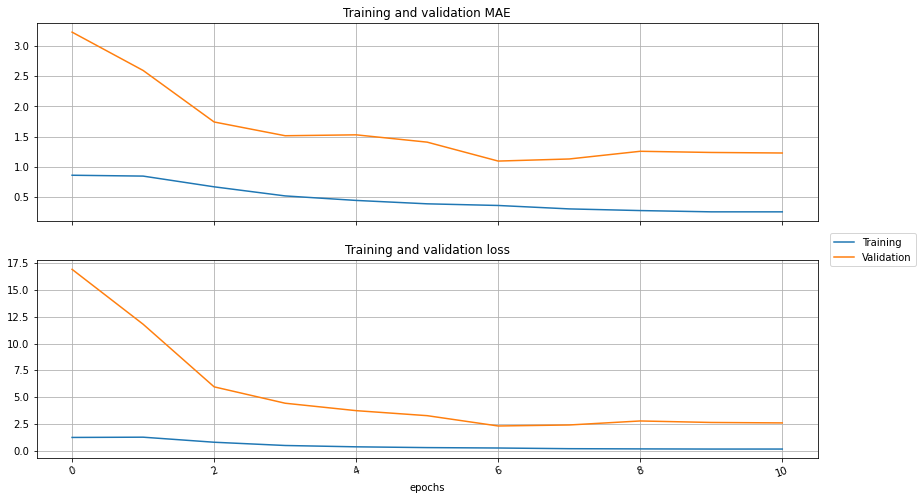

In [23]:
linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

## MLP model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
232/232 - 1s - loss: 0.9816 - mean_absolute_error: 0.7738 - val_loss: 3.9206 - val_mean_absolute_error: 1.4563

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
232/232 - 1s - loss: 1.0111 - mean_absolute_error: 0.8027 - val_loss: 3.9152 - val_mean_absolute_error: 1.4546

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
232/232 - 1s - loss: 1.0078 - mean_absolute_error: 0.8063 - val_loss: 3.9121 - val_mean_absolute_error: 1.4531

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
232/232 - 1s - loss: 1.0062 - mean_absolute_error: 0.8063 - val_loss: 3.9100 - val_mean_absolute_error: 1.4520

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
232/232 - 1s - loss: 1.0063 - mean_absolute_error: 0.8068 - val_loss: 3.9085

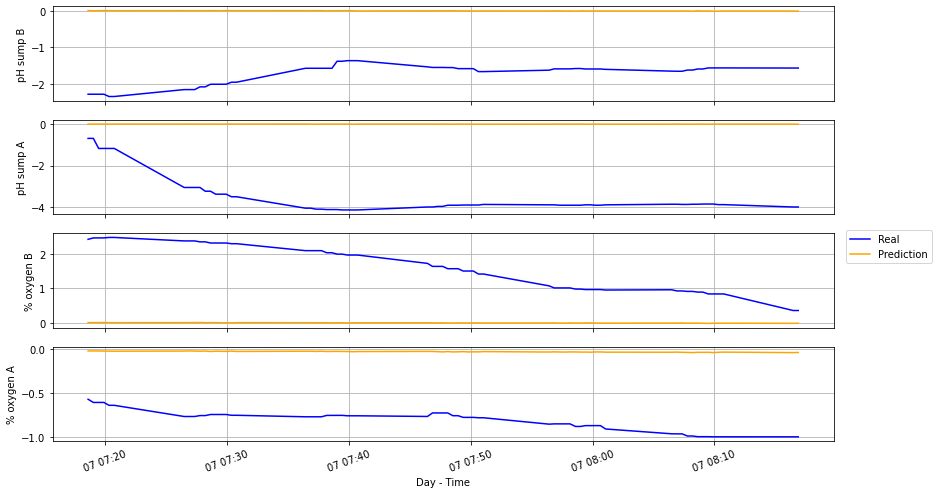

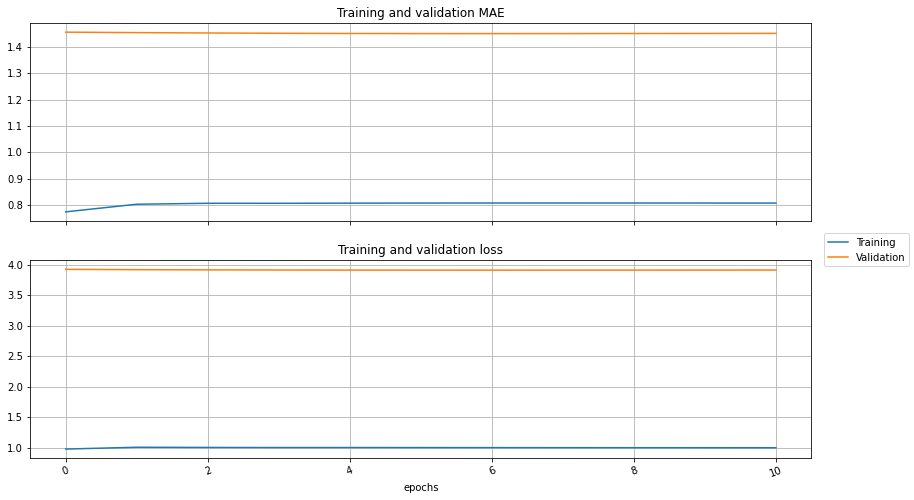

In [24]:
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

## LSTM RNN model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
232/232 - 79s - loss: 0.8219 - mean_absolute_error: 0.6967 - val_loss: 4.5482 - val_mean_absolute_error: 1.5812

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
232/232 - 78s - loss: 0.9557 - mean_absolute_error: 0.7676 - val_loss: 3.9851 - val_mean_absolute_error: 1.4218

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
232/232 - 78s - loss: 1.1377 - mean_absolute_error: 0.8575 - val_loss: 3.7935 - val_mean_absolute_error: 1.3744

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
232/232 - 78s - loss: 1.0359 - mean_absolute_error: 0.8333 - val_loss: 3.8002 - val_mean_absolute_error: 1.3789

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
232/232 - 78s - loss: 1.0489 - mean_absolute_error: 0.8305 - val_loss: 4

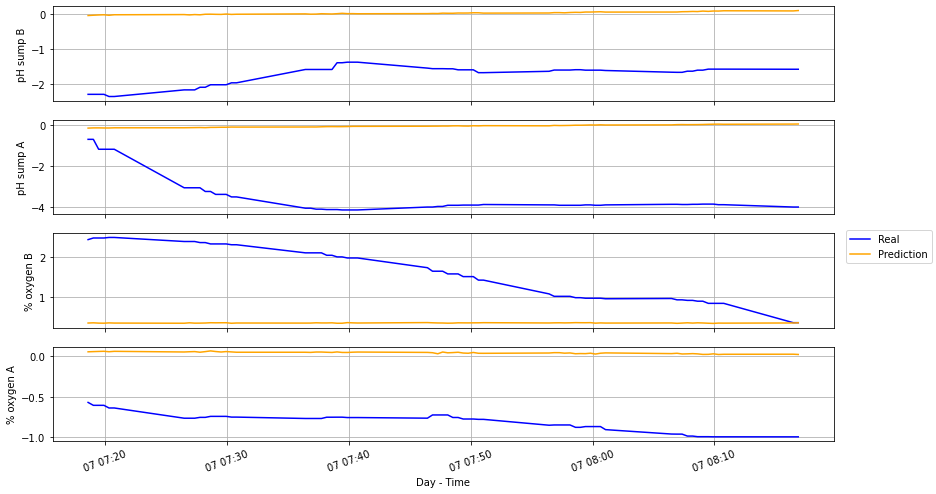

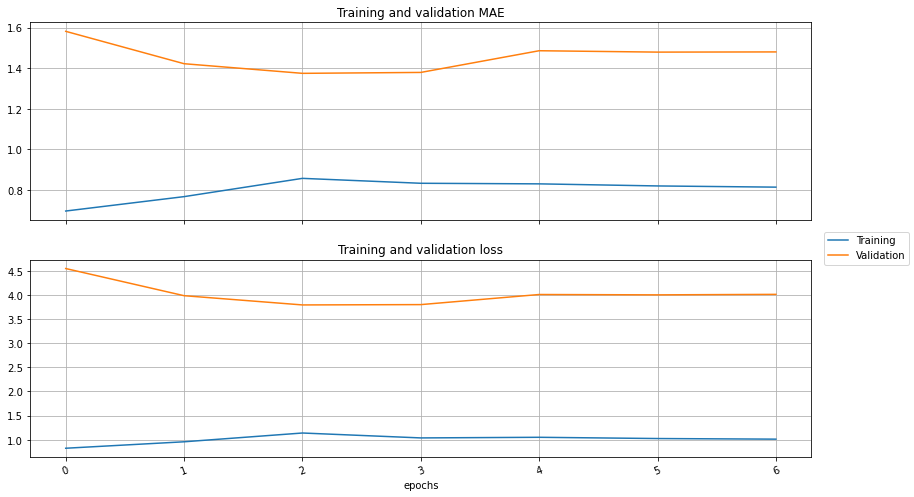

In [25]:
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

## GRU RNN model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
232/232 - 67s - loss: 0.6927 - mean_absolute_error: 0.6290 - val_loss: 4.7785 - val_mean_absolute_error: 1.6868

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
232/232 - 66s - loss: 0.7702 - mean_absolute_error: 0.6663 - val_loss: 4.3369 - val_mean_absolute_error: 1.5970

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
232/232 - 66s - loss: 0.6404 - mean_absolute_error: 0.5991 - val_loss: 4.6810 - val_mean_absolute_error: 1.5786

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
232/232 - 66s - loss: 0.6970 - mean_absolute_error: 0.6288 - val_loss: 4.8478 - val_mean_absolute_error: 1.6647

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
232/232 - 66s - loss: 0.6346 - mean_absolute_error: 0.5898 - val_loss: 3

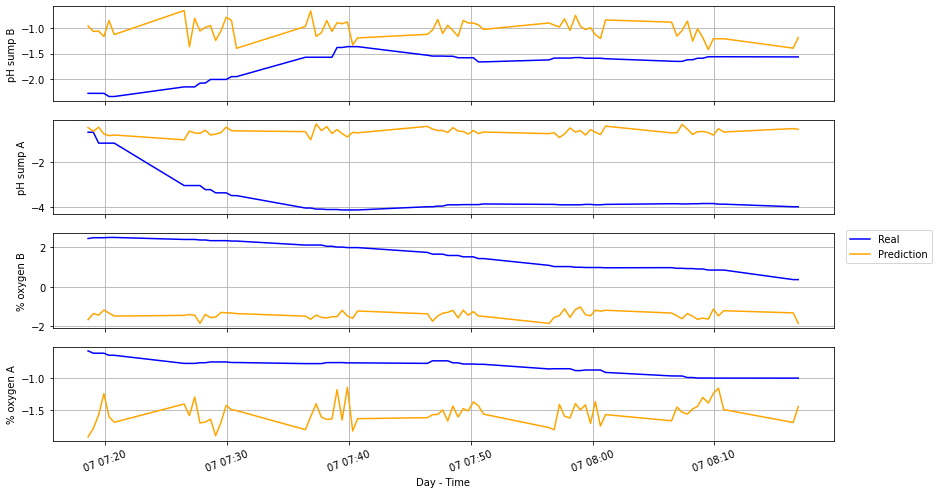

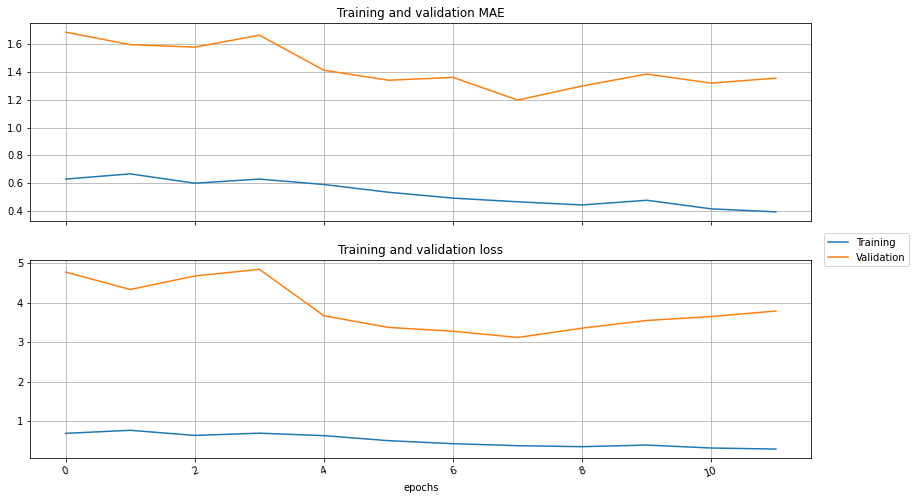

In [26]:
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

TODO:
- UN-NORMALIZATION FUNCTION
- CLEAN DATA
- TRY ONE NETWORK PER OUTPUT